--- Konteyner ve Atık Türüne Göre Ortalama Doluluk ---
Recyclable fraction       Mixed  Non Recyclable  Recyclable
Container Type                                             
Accordion             72.277228       67.252500   70.432432
BIM-3 FTI bottentomd  65.972152       67.048246   66.847222
Cubic                 64.255833       62.517757   70.596875
Diamond               72.493137       67.346429   72.076699
Fiberglass Igloo-a    70.038710       69.402542   70.988288
Fiberglass Igloo-b    69.920339       67.682796   70.989899
Lindstrom City        69.615574       68.836885   67.326496
Lindstrom-a           70.078378       69.047761   67.046774
Lindstrom-b           70.367826       68.072381   67.818681
Malmobehallare        66.712121       66.660000   71.274790
Rectangular           70.910101       66.786179   68.231818
Rectangular Farmland  69.579091       70.021429   68.415315
Silvertop-a           65.208182       65.917925   70.805051
Silvertop-b           67.859821       68.0271

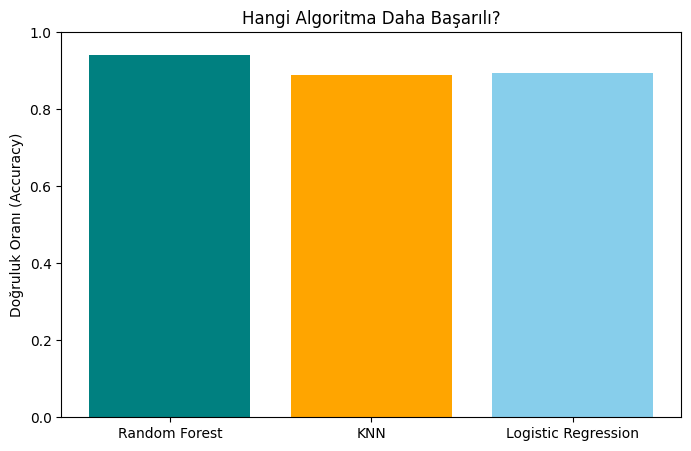

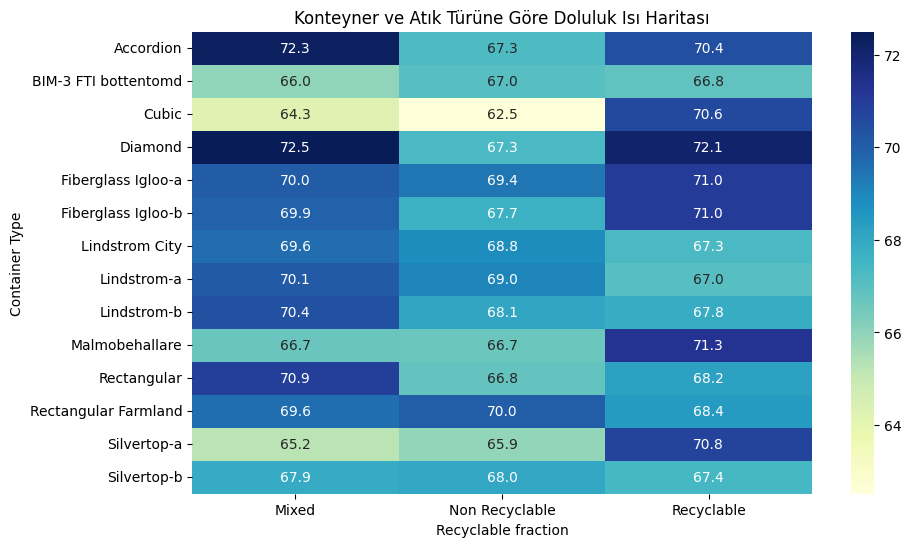

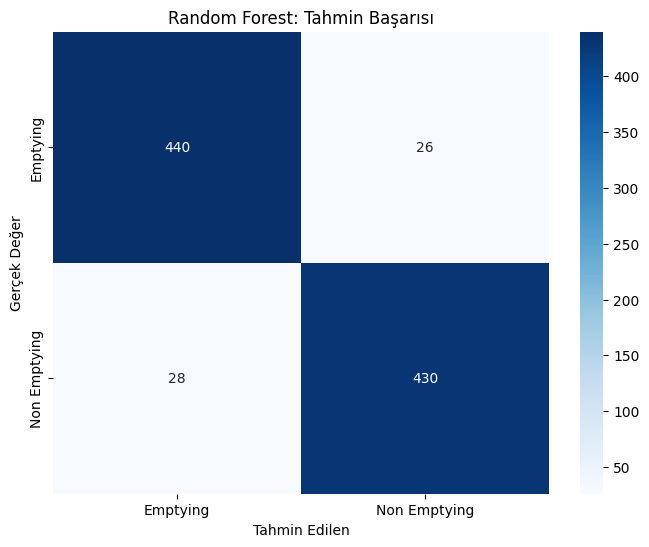

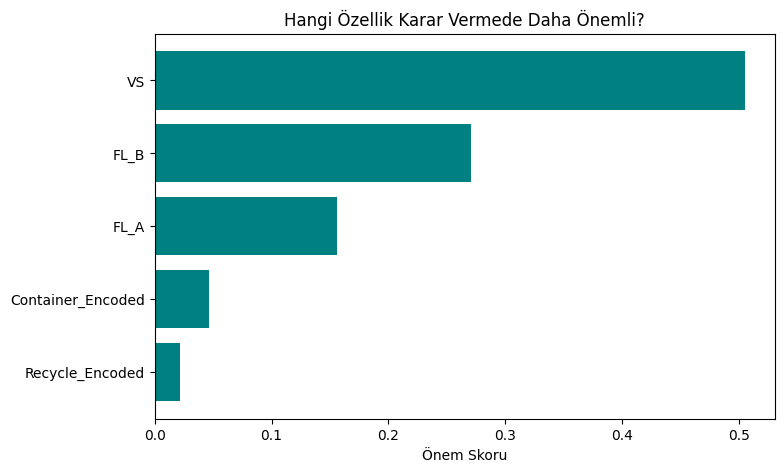

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

#veriler dosyadan okunur ve makine öğrenmesi boş verilerde çalışmayacağı için-> eksik ve hatalı olan verileri silinir.
df = pd.read_csv('Smart_Bin.csv')
df.dropna(inplace=True)
df.head()

#konteyner, atık türüne göre ortalama doluluk seviyesi hesaplama kısmı(hangi konteyner hangi atıkta daha çok doluyor?)
#bu adım model kurmadan önce verinin anlaşılması için yapılır.
pivot_analiz = df.pivot_table(index='Container Type',
                              columns='Recyclable fraction',
                              values='FL_B',
                              aggfunc='mean')
print("--- Konteyner ve Atık Türüne Göre Ortalama Doluluk ---")
print(pivot_analiz)

#enable işlemi ile kategorik veriler sayısal verilere dönüştürülür.
#çok sayıda farklı kategori olduğu için de "label encoder" kullanıldı.
le = LabelEncoder()
df['Container_Encoded'] = le.fit_transform(df['Container Type'])
df['Recycle_Encoded'] = le.fit_transform(df['Recyclable fraction'])
df['Class_Encoded'] = le.fit_transform(df['Class'])

#modelin hangi bilgilere bakarak karar vereceği seçilir. x-> girdiler, y-> çıktı.
features = ['FL_B', 'FL_A', 'VS', 'Container_Encoded', 'Recycle_Encoded']
X = df[features]
y = df['Class_Encoded']

#verinin %80'lik kısmı modeli eğitmek için, %20'lik kısmı da modeli sınamak için ayrılır.
#bunun amacı modelin ezber mi yapıyor yoksa gerçekten öğreniyor mu anlamaktır.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#karmaşık ve gerçek hayata yakın verilerde yüksek başarı göstermesinden kaynaklı RandomForestClassifier seçildi.
#tek bir karar yerine çoklu kararlarla daha doğru sonuç üretir.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

#knn modeli ve logistic regression için ölçeklendirme şarttır.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
knn_pred = knn_model.predict(X_test_scaled)

lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)

print("\n--- Random Forest Detaylı Performans Raporu ---")
print(classification_report(y_test, rf_pred, target_names=le.classes_))

print("\n--- KNN Detaylı Performans Raporu ---")
print(classification_report(y_test, knn_pred, target_names=le.classes_))

print("\n--- Logistic Regression Detaylı Performans Raporu ---")
print(classification_report(y_test, lr_pred , target_names=le.classes_))

#sonuçların karşılaştırılması
print(f"Random Forest Başarı Skoru: {accuracy_score(y_test, rf_pred):.2f}")
print(f"KNN Başarı Skoru: {accuracy_score(y_test, knn_pred):.2f}")
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, lr_pred):.4f}")

#GRAFİK-1: model başarı karşılaştırması
plt.figure(figsize=(8, 5))
models = ['Random Forest', 'KNN', 'Logistic Regression']
accuracies = [accuracy_score(y_test, rf_pred), accuracy_score(y_test, knn_pred), accuracy_score(y_test, lr_pred)]
plt.bar(models, accuracies, color=['teal', 'orange', 'skyblue']) # Her model için farklı renk
plt.ylabel('Doğruluk Oranı (Accuracy)')
plt.title('Hangi Algoritma Daha Başarılı?')
plt.ylim(0, 1)
plt.show()

# GRAFİK-2: pivot analizinin ısı haritası
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_analiz, annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('Konteyner ve Atık Türüne Göre Doluluk Isı Haritası')
plt.show()

# GRAFİK-3: RF karmaşıklık matrisi
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Random Forest: Tahmin Başarısı')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek Değer')
plt.show()

# GRAFİK-4: Özellik Önem Sırası
plt.figure(figsize=(8, 5))
importances = rf_model.feature_importances_
indices = np.argsort(importances)
plt.barh([features[i] for i in indices], importances[indices], color='teal')
plt.xlabel('Önem Skoru')
plt.title('Hangi Özellik Karar Vermede Daha Önemli?')
plt.show()